In [1]:
### used to plot all the signal/background distribution in the selection section

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2t


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'
lumi = {'MC_Summer16':35.9*1000,
        'MC_Fall17': 41.5*1000, 
        'MC_Fall18':  59.7*1000 ,
       
       }


ntupler_version = 'V1p17/'
analyzer_version = "/v1/v113/" #has all the signal layer

years = ['MC_Summer16', 'MC_Fall17', 'MC_Fall18']

mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
fpath['mc'] = mc_path + 'ggH_HToSSTobbbb_MH-125.root'
analyzer_version = "/v5/v100/"
data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/Data2018/'+analyzer_version+'/normalized/'
fpath['data'] = data_path +'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
NEvents = {}
for k,v in fpath.items():
    print (k, v)
   
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    print(len(a))



mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v113//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 1314995700.0
75481
data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//Data2018//v5/v100//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0
14129474


# load variables

In [3]:
%%time
r_denom = []
z_denom = []
r_nom = []
z_nom = []
weight_nom = []
weight_denom = []
llp_r = []
llp_z =[]
weight_llp = []


leading_jet = {}
time_spread = {}
mevetos = {}
time = {}
me11 = {}
me12 = {}
me1112 = {}
re12 = {}
mb1 = {}
rb1 = {}
eta = {}
clusterTime = {}
cut_based_id = {}
weight_time = {}
weight_me11 = {}
weight_me12 = {}
weight_re12 = {}
weight_mb1 = {}
weight_rb1 = {}
weight_eta = {}
weight_time = {}
weight_time_spread = {}
weight_jet = {}
weight_me1112 = {}
cscRechitClusterEta = {}
cscRechitClusterNStation = {}
cscRechitClusterAvgStation = {}
dphiMet_cluster = {}
nCsc = {}
weight = {}
hit_per_chamber = {}
hit_per_chamber_notme1112 = {}
hit_per_chamber_me1112 = {}
diff = {}
nCsc_sub = {}
for k in ['mc', 'data_intime','data_oot']:
    if 'data' in k: T = tree['data']
    else: T = tree[k]
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
    ########### SELECTION: EVENTS ############
    if 'data' in k:
        sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) >= 0
    else:
        sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) >= 1
    sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
    sel_ev = np.logical_and(sel_ev ,T.array('metEENoise') > 200)
    sel_ev  = np.logical_and(sel_ev, T.array('category') == 0)
    sel_ev = np.logical_and(sel_ev ,T.array('nLeptons') == 0)
    sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_ev = np.logical_and(sel_ev, (T.array('nDtRings')+T.array('nCscRings'))<10)


    sel_ev_temp = np.logical_and(sel_ev, (np.abs(T.array('jetEta')) < 2.4).sum()>0)


    leading_jet[k] = T.array('jetPt')[np.abs(T.array('jetEta')) < 2.4][sel_ev_temp][:,0]
    if not 'data' in k:
        weight_jet[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev_temp]
    else:
        weight_jet[k] = leading_jet[k]*0.0 +1.0
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)

    
    cluster_index = '3'
    ########### SELECTION: CLUSTERS ############
    if 'data' in k:
        sel_rechitcluster = np.logical_not(T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc'))
    else:
        sel_rechitcluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc')
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum()==1)
    if 'oot' in k:
        
        sel = [T.array('cscRechitCluster'+cluster_index+'TimeTotal') < -12.5,]
    elif k == 'data_intime':
        sel = [np.logical_and(T.array('cscRechitCluster'+cluster_index+'Size') < 80,\
                              np.logical_and(T.array('cscRechitCluster'+cluster_index+'TimeTotal') > -5.0, T.array('cscRechitCluster'+cluster_index+'TimeTotal') < 12.5)),]
    else:
        sel = [np.logical_and(T.array('cscRechitCluster'+cluster_index+'TimeTotal') > -5.0, T.array('cscRechitCluster'+cluster_index+'TimeTotal') < 12.5),]
    sel+=[
        T.array('cscRechitCluster'+cluster_index+'JetVetoPt') < 10,
        T.array('cscRechitCluster'+cluster_index+'MuonVetoPt') < 20,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11') <= 0,
         T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11') <= 0,
        T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12') <= 0,
        T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4') <= 0,
        T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4') <= 0,
        np.abs(T.array('cscRechitCluster'+cluster_index+'Eta')) < 2.0,
         T.array('cscRechitCluster'+cluster_index+'TimeSpread') < 20,
    ]
    clusterTime[k] =  T.array('cscRechitCluster'+cluster_index+'TimeTotal')[sel_rechitcluster&sel[11]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]\
                                                                          &sel[7]&sel[8]&sel[9]][sel_ev]
    if not 'data' in k:weight_time[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+clusterTime[k]*0.0
    else: weight_time[k] = clusterTime[k]*0.0 +1.0
        
        
    hit_per_chamber[k] =     list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus13')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus21')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus22')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus31')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus32')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus41')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus42')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus13')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus21')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus22')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus31')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus32')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus41')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus42')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) 



    hit_per_chamber_me1112[k] =     list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) 
 
        
    hit_per_chamber_notme1112[k] =    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus13')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus21')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus22')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus31')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus32')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus41')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus42')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus13')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus21')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus22')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus31')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus32')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus41')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) + \
    list(T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus42')[sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev].flatten()) 
        
    me11[k] =  (T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11')+T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11'))\
    [sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev]
    print(len(me11[k]),np.count_nonzero(me11[k]))
    if not 'data' in k:weight_me11[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+me11[k]*0.0
    else: weight_me11[k] = me11[k]*0.0 +1.0
    me12[k] =  (T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12')+T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12'))\
    [sel_rechitcluster&sel[0]&sel[1]&sel[2]][sel_ev]
    if not 'data' in k:weight_me12[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+me12[k]*0.0
    else: weight_me12[k] = me12[k]*0.0 +1.0
    
    me1112[k] = me11[k] + me12[k]
    weight_me1112[k] = weight_me12[k]
    
    re12[k] =  T.array('cscRechitCluster'+cluster_index+'_match_RE12_0p4')[sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]][sel_ev]
    if not 'data' in k:weight_re12[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+re12[k]*0.0
    else: weight_re12[k] = re12[k]*0.0 +1.0
    
    mb1[k] =  T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4')[sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]][sel_ev]
    if not 'data' in k:weight_mb1[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+mb1[k]*0.0
    else: weight_mb1[k] = mb1[k]*0.0 +1.0
    
    rb1[k] = T.array('cscRechitCluster'+cluster_index+'_match_RB1_0p4')[sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]][sel_ev]
    if not 'data' in k:weight_rb1[k] =(T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+rb1[k]*0.0
    else: weight_rb1[k] = rb1[k]*0.0 +1.0
    
    eta[k] =  T.array('cscRechitCluster'+cluster_index+'Eta')[sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]\
                                                                      &sel[7]&sel[8]&sel[9]&sel[11]][sel_ev]
    if not 'data' in k:weight_eta[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+eta[k]*0.0
    else: weight_eta[k] = eta[k]*0.0 +1.0
    
    time_spread[k] = T.array('cscRechitCluster'+cluster_index+'TimeSpread')[sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]\
                                                                          &sel[7]&sel[8]&sel[9]&sel[10]][sel_ev]
    if not 'data' in k:weight_time_spread[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+time_spread[k]*0.0
    else: weight_time_spread[k] = time_spread[k]*0.0 +1.0
    
    
    
    sel_rechitcluster = sel_rechitcluster&sel[0]&sel[1]&sel[2]&sel[3]&sel[4]&sel[5]&sel[6]&sel[7]&sel[8]&sel[9]&sel[10]&sel[11]
    cscRechitClusterEta[k] =  T.array('cscRechitCluster'+cluster_index+'Eta')[sel_rechitcluster][sel_ev]
    cscRechitClusterNStation[k] =  T.array('cscRechitCluster'+cluster_index+'NStation10')[sel_rechitcluster][sel_ev]
    cscRechitClusterAvgStation[k] =  T.array('cscRechitCluster'+cluster_index+'AvgStation10')[sel_rechitcluster][sel_ev]
    
    
    cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
    cond1 = np.logical_and(cscRechitClusterNStation[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation[k])==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(cscRechitClusterNStation[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
    cut_based_id[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
                
    nCsc[k] =  T.array('cscRechitCluster'+cluster_index+'Size')[sel_rechitcluster][sel_ev]
    dphiMet_cluster[k] =  T.array('cscRechitCluster'+cluster_index+'MetEENoise_dPhi')[sel_rechitcluster][sel_ev]
        
    if not 'data' in k:weight[k] = (T.array('higgsPtWeight')*T.array('pileupWeight')*T.array('weight')*T.array('metSF'))[sel_ev]+cscRechitClusterEta[k]*0.0
    else: weight[k] = cscRechitClusterEta[k]*0.0 +1.0
        
    
    
    Plus11 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus11')[sel_rechitcluster][sel_ev]
    Plus12 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus12')[sel_rechitcluster][sel_ev]
    Plus13 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus13')[sel_rechitcluster][sel_ev]
    Plus21 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus21')[sel_rechitcluster][sel_ev]
    Plus22 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus22')[sel_rechitcluster][sel_ev]
    Plus31 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus31')[sel_rechitcluster][sel_ev]
    Plus32 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus32')[sel_rechitcluster][sel_ev]
    Plus41 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus41')[sel_rechitcluster][sel_ev]
    Plus42 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberPlus42')[sel_rechitcluster][sel_ev]
    Minus11 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus11')[sel_rechitcluster][sel_ev]
    Minus12 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus12')[sel_rechitcluster][sel_ev]
    Minus13 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus13')[sel_rechitcluster][sel_ev]
    Minus21 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus21')[sel_rechitcluster][sel_ev]
    Minus22 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus22')[sel_rechitcluster][sel_ev]
    Minus31 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus31')[sel_rechitcluster][sel_ev]
    Minus32 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus32')[sel_rechitcluster][sel_ev]
    Minus41 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus41')[sel_rechitcluster][sel_ev]
    Minus42 = T.array('cscRechitCluster'+cluster_index+'NRechitChamberMinus42')[sel_rechitcluster][sel_ev]
    
    cut = 5
    Plus11[Plus11>cut] = 0
    Plus12[Plus12>cut] = 0
    Plus13[Plus13>cut] = 0
    Plus21[Plus21>cut] = 0
    Plus22[Plus22>cut] = 0
    Plus31[Plus31>cut] = 0
    Plus32[Plus32>cut] = 0
    Plus41[Plus41>cut] = 0
    Plus42[Plus42>cut] = 0

    Minus11[Minus11>cut] = 0
    Minus12[Minus12>cut] = 0
    Minus13[Minus13>cut] = 0
    Minus21[Minus21>cut] = 0
    Minus22[Minus22>cut] = 0
    Minus31[Minus31>cut] = 0
    Minus32[Minus32>cut] = 0
    Minus41[Minus41>cut] = 0
    Minus42[Minus42>cut] = 0

    nCsc_sub[k] = nCsc[k]-Plus11-Plus12-Plus13-Plus21-Plus22-Plus31-Plus32-Plus41-Plus42-Minus11-Minus12-Minus13-Minus21-Minus22-Minus31-Minus32-Minus41-Minus42

    diff[k] = nCsc[k]-nCsc_sub[k]





46040 6060
745773 40220
745773 86455
CPU times: user 8min 42s, sys: 3min 59s, total: 12min 41s
Wall time: 17min 38s
Parser   : 114 ms


# Plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


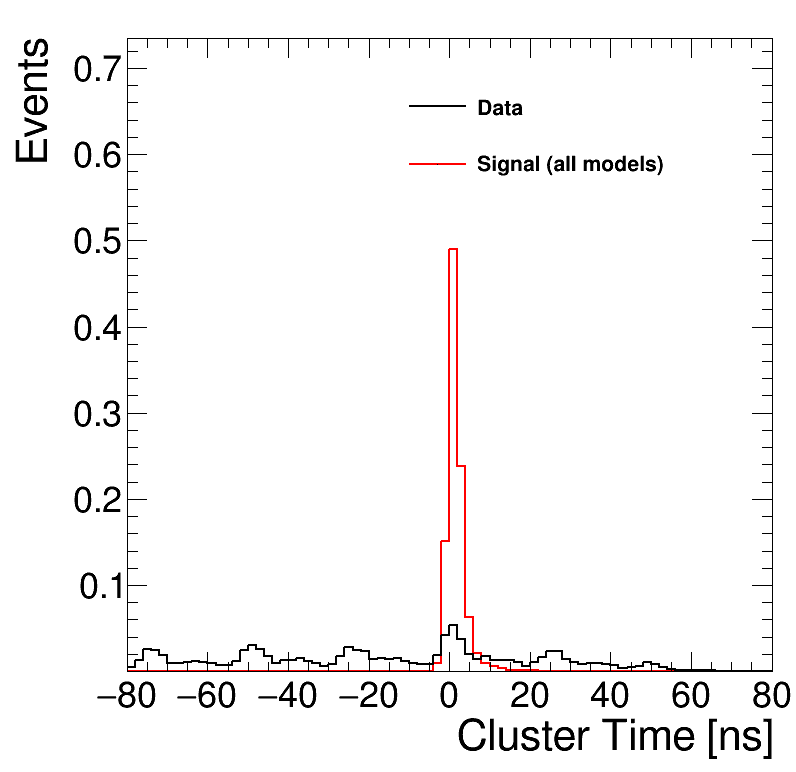

In [8]:
import os
var = [leading_jet, me1112,re12,rb1,mb1,eta,time_spread, clusterTime, cscRechitClusterEta, cscRechitClusterNStation,cscRechitClusterAvgStation]
weights = [weight_jet, weight_me1112,weight_re12,weight_rb1,weight_mb1,weight_eta,weight_time_spread,weight_time, weight,weight,weight]
xaxis = ['Leading Jet p_{T} [GeV]','N_{ME11/12 hits}','N_{RE1/2 hits}','N_{RB1 hits}','N_{MB1 hits}','Cluster #eta','Time Spread [ns]',\
         'Cluster Time [ns]','cluster #eta', 'N_{stations}','Avg Station Number']
name = ['leading_jet','me1112','re12','rb1','mb1','eta','time_spread','clusterTime','cscRechitClusterEta', 'cscRechitClusterNStation','cscRechitClusterAvgStation']
binning = [[40,0,1000],[50,0,50], [5,0,5], [40,0,40], [40,0,40], [50,0.5,2.5], [25,0,50],[80,-80,80],[24,0.8,2.0],[5,0,5],[24,0,5]]

    
for index in range(len(var)):
    if not index == 7:continue
    with_background = 1
#     if index <=1 or index == 5 or index >= 7:with_background == 1
#     else: with_background =0


    if index == 0:
        leg = rt.TLegend(0.6,0.75,0.90,0.90)
    elif index == 5:
        leg = rt.TLegend(0.2,0.75,0.6,0.90)
    else:
        leg = rt.TLegend(0.5,0.75,0.90,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)
    h = {}

    h['sig'] = create_TH1D(var[index]['mc'].flatten(),  axis_title=[xaxis[index], 'Events'], binning = binning[index],weights = weights[index]['mc'].flatten())
    if with_background:
        if index == 0 or index == 7:
            h['data_intime'] = create_TH1D(var[index]['data_intime'].flatten(),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
            leg.AddEntry(h['data_intime'], 'Data')
            leg.AddEntry(h['sig'], 'Signal (all models)')
#         elif index >7:
#             h['data_oot'] = create_TH1D(var[index]['data_oot'].flatten(),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
#             leg.AddEntry(h['data_oot'], 'OOT data')
#             leg.AddEntry(h['sig'], 'Signal (all models)')
        else:
            h['data_intime'] = create_TH1D(np.abs(var[index]['data_intime'].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
            h['data_oot'] = create_TH1D(np.abs(var[index]['data_oot'].flatten()),  axis_title=[xaxis[index], 'Events'], binning = binning[index])
            leg.AddEntry(h['data_intime'], 'in-time data (N_{rechits} < 80)')
            leg.AddEntry(h['data_oot'], 'OOT data (time < -12.5 ns)')
            leg.AddEntry(h['sig'], 'Signal (all models)')
    for k, hist in h.items():
        hist.Scale(1./hist.Integral())

    if index == 0 or index == 5:
        h['sig'].GetYaxis().SetRangeUser(20*min(map(lambda x: x.GetMaximum(), list(h.values()))), 10.0*max(map(lambda x: x.GetMaximum(), list(h.values()))))
    if index == 4 or index == 3:
        h['sig'].GetYaxis().SetRangeUser(0.000005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 1.5*max(map(lambda x: x.GetMaximum(), list(h.values()))))
    elif index >= 8:
        h['sig'].GetYaxis().SetRangeUser(0.005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 1.2*max(map(lambda x: x.GetMaximum(), list(h.values()))))

    else:
        h['sig'].GetYaxis().SetRangeUser(0.0005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 1.5*max(map(lambda x: x.GetMaximum(), list(h.values()))))

    if with_background: h['sig'].SetLineColor(2)
    else:h['sig'].SetLineColor(1)
    h['sig'].DrawNormalized('hist same')
    if with_background:
#         if index<=7:
#             h['data_intime'].SetLineColor(1)
#             h['data_intime'].Draw('hist same')
#             if index > 0 and index <7:
#                 h['data_oot'].SetLineColor(4)
#                 h['data_oot'].Draw('hist same')
#         else:
#             h['data_oot'].SetLineColor(1)
#             h['data_oot'].Draw('hist same')
        h['data_intime'].SetLineColor(1)
        h['data_intime'].Draw('hist same')
        if not (index == 0 or index == 7):
            h['data_oot'].SetLineColor(4)
            h['data_oot'].Draw('hist same')
        leg.Draw()

#     if index == 0 or index >=5:
#         if index == 0:
#             arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
#             l = rt.TLine(50,0, 50, 1)
#             arrow.SetLineWidth(2)        
#             arrow.DrawArrow(50,0.5,150,0.5)
#         elif index == 5:
#             arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
#             l = rt.TLine(2,0, 2, 0.4)
#             arrow.SetLineWidth(2)        
#             arrow.DrawArrow(1.7,0.1,2,0.1)
#         elif index == 7:
#             arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
#             arrow1 = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
#             l = rt.TLine(12.5,0, 12.5, 0.4)
#             l1 = rt.TLine(-5,0, -5, 0.4)
#             l1.SetLineWidth(2)
#             l1.Draw()
#             arrow.SetLineWidth(2)        
#             arrow1.SetLineWidth(2)        
#             arrow.DrawArrow(7,0.35,12.5,0.35)
#             arrow1.DrawArrow(-5,0.35,-1,0.35)
#         else:
#             arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")

#             l = rt.TLine(20,0, 20, 0.4)
#             arrow.SetLineWidth(2)        
#             arrow.DrawArrow(15,0.1,20,0.1)

#         l.SetLineWidth(2)
#     #     l.SetLineStyle(2)
#         l.Draw()    



    c.SetRightMargin(0.03)
    # c.SetLogx()
    if index < 7: c.SetLogy()

    c.Draw()
    outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version
#     if not os.path.isdir(outDir):os.makedirs(outDir)
#     if with_background:
#         c.SaveAs(outDir+name[index]+'.png')
#         c.SaveAs(outDir+name[index]+'.C')
#     else:
#         c.SaveAs(outDir+name[index]+'_sig.png')
#         c.SaveAs(outDir+name[index]+'_sig.C')


# time plot (paper version)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100/clusterTime_pas.png has been created
Info in <TCanvas::Print>: pdf file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100/clusterTime_pas.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100/clusterTime_pas.C has been generated


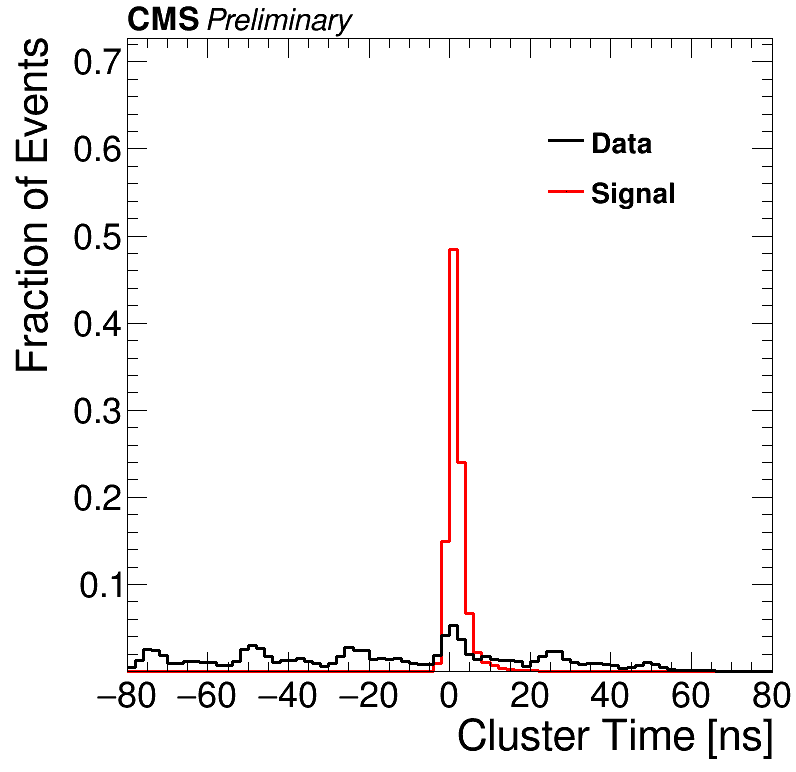

In [26]:
import os

    
with_background = 1

leg = rt.TLegend(0.68,0.72,0.93,0.85)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}

h['sig'] = create_TH1D(clusterTime['mc'].flatten(),  axis_title=['Cluster Time [ns]', 'Fraction of Events'], binning = [80,-80,80],weights = weight_time['mc'].flatten())
h['data_intime'] = create_TH1D(clusterTime['data_intime'].flatten(),  axis_title=['Cluster Time [ns]', 'Fraction of Events'], binning = [80,-80,80])
leg.AddEntry(h['data_intime'], 'Data')
leg.AddEntry(h['sig'], 'Signal')

for k, hist in h.items():
    hist.Scale(1./hist.Integral())
    hist.SetLineWidth(3)

h['sig'].GetYaxis().SetRangeUser(0.0005*min(map(lambda x: x.GetMaximum(), list(h.values()))), 1.5*max(map(lambda x: x.GetMaximum(), list(h.values()))))

h['sig'].SetLineColor(2)
h['data_intime'].SetLineColor(1)

h['sig'].Draw('hist same')

h['data_intime'].Draw('hist same')
leg.Draw()


CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
# CMS_lumi.relPosX = 0.15
# CMS_lumi.relPosY = 0.08   
CMS_lumi.relPosX = 0.12
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Preliminary"
# CMS_lumi.extraText   = "Supplementary"

CMS_lumi.CMS_lumi(c, 0, 0)


c.SetRightMargin(0.03)
c.Draw()
outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version
if not os.path.isdir(outDir):os.makedirs(outDir)
fileName = outDir +'clusterTime'
if CMS_lumi.writeExtraText and CMS_lumi.extraText == "Preliminary": fileName += "_pas"
elif CMS_lumi.writeExtraText and CMS_lumi.extraText == "Supplementary": fileName += "_paper"



c.SaveAs(fileName + ".png")
c.SaveAs(fileName + ".pdf")
c.SaveAs(fileName + ".C")


# Plot for eta when Nstation > 1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100/eta_nStation2.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100/eta_nStation2.C has been generated


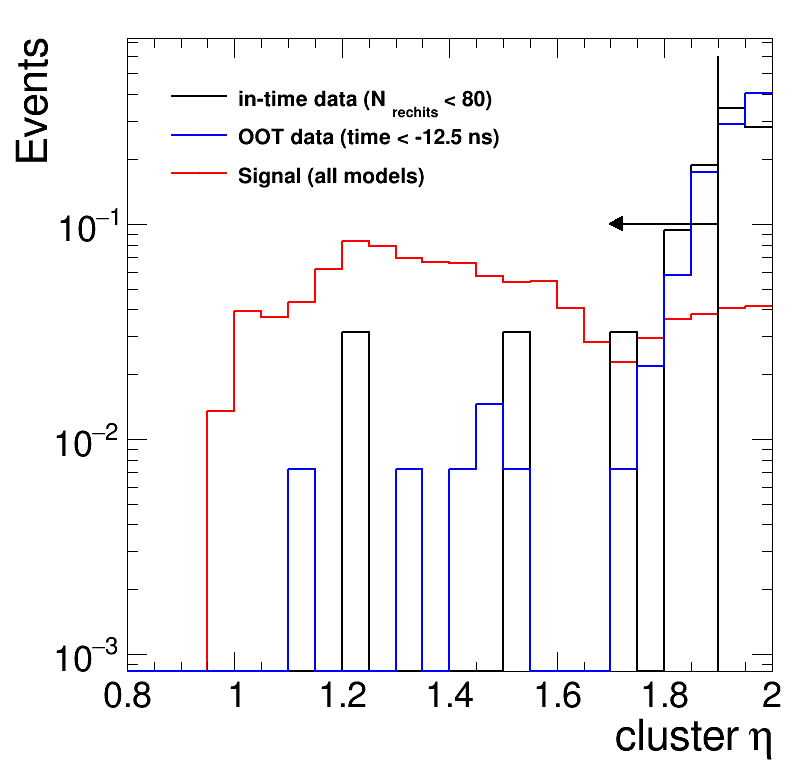

In [10]:

with_background = True
leg = rt.TLegend(0.2,0.75,0.6,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}

temp = []
w = []
bins = [24,0.8,2.0]
xaxis = 'cluster #eta'
condition = cscRechitClusterNStation['mc'].flatten()>1
h['sig'] = create_TH1D(np.abs(cscRechitClusterEta['mc'].flatten()[condition]),  axis_title=[xaxis, 'Events'], binning = bins,weights = weight['mc'].flatten()[condition])
if with_background:
    
    h['data_intime'] = create_TH1D(np.abs(cscRechitClusterEta['data_intime'].flatten()[cscRechitClusterNStation['data_intime'].flatten()>1]),  \
                                   axis_title=[xaxis, 'Events'], binning = bins)
    h['data_oot'] = create_TH1D(np.abs(cscRechitClusterEta['data_oot'].flatten()[cscRechitClusterNStation['data_oot'].flatten()>1]), \
                                axis_title=[xaxis, 'Events'], binning = bins)
    leg.AddEntry(h['data_intime'], 'in-time data (N_{rechits} < 80)')
    leg.AddEntry(h['data_oot'], 'OOT data (time < -12.5 ns)')
    leg.AddEntry(h['sig'], 'Signal (all models)')
for k, hist in h.items():
    hist.Scale(1./hist.Integral())
h['sig'].GetYaxis().SetRangeUser(0.01*min(map(lambda x: x.GetMaximum(), list(h.values()))), 1.8*max(map(lambda x: x.GetMaximum(), list(h.values()))))

h['sig'].SetLineColor(2)
h['sig'].DrawNormalized('hist same')
if with_background:
    h['data_intime'].SetLineColor(1)
    h['data_intime'].DrawNormalized('hist same')
    h['data_oot'].SetLineColor(4)
    h['data_oot'].DrawNormalized('hist same')

arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
l = rt.TLine(1.9,0, 1.9, 0.6)
arrow.SetLineWidth(2)
arrow.DrawArrow(1.7,0.1,1.9,0.1)
l.SetLineWidth(2)
l.Draw()    
    
c.SetRightMargin(0.03)
# c.SetLogx()
c.SetLogy()
leg.Draw()
c.Draw()
# leg.Draw()
outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version


if with_background:
    c.SaveAs(outDir+'eta_nStation2.png')
    c.SaveAs(outDir+'eta_nStation2.C')
else:
    c.SaveAs(outDir+'/eta_nStation2_sig.png')
    c.SaveAs(outDir+'/eta_nStation2_sig.C')



# Plot for eta vs avgStation when Nstation == 1

1202


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//eta_avgStation_nStation1sig.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies//v5/v100//eta_avgStation_nStation1sig.C has been generated


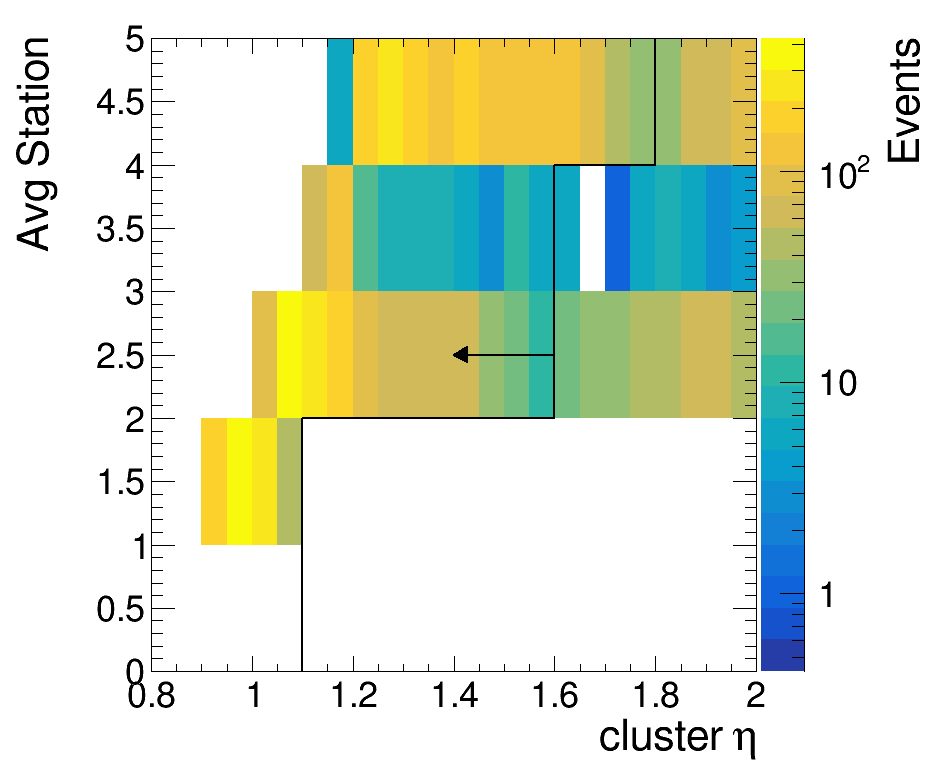

In [13]:
key = 'sig'
# key = 'data_intime'
# key = 'data_oot'
leg = rt.TLegend(0.2,0.75,0.6,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 950, 800)
rt.gStyle.SetOptFit(1011)
h = {}

temp_eta = []
temp_avgstation = []
w = []
bins = [24,0.8,2.0, 5,0,5]
xaxis = 'cluster #eta'
yaxis = 'Avg Station'
condition = cscRechitClusterNStation['mc'].flatten() == 1
h['sig'] = create_TH2D(np.column_stack((np.abs(cscRechitClusterEta['mc'].flatten()[condition]),np.abs(cscRechitClusterAvgStation['mc'].flatten()[condition]))),\
                       axis_title=[xaxis, yaxis, 'Events'], binning = bins,weights = weight['mc'].flatten()[condition])
    

cond = cscRechitClusterNStation['data_intime'].flatten()==1
h['data_intime'] = create_TH2D(np.column_stack((np.abs(cscRechitClusterEta['data_intime'].flatten()[cond]),cscRechitClusterAvgStation['data_intime'].flatten()[cond])),\
                            axis_title=[xaxis,  yaxis,'Events'], binning = bins)
cond = cscRechitClusterNStation['data_oot'].flatten()==1
h['data_oot'] = create_TH2D(np.column_stack((np.abs(cscRechitClusterEta['data_oot'].flatten()[cond]),cscRechitClusterAvgStation['data_oot'].flatten()[cond])),\
                            axis_title=[xaxis,  yaxis,'Events'], binning = bins)
print(np.count_nonzero(cscRechitClusterNStation['data_oot'].flatten()==1))
# for k, hist in h.items():
#     hist.Scale(1./hist.Integral())
h[key].Draw('colz')


arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
l = []
l.append(rt.TLine(1.8, 4, 1.8, 5))
l.append(rt.TLine(1.6, 4, 1.8, 4))
l.append(rt.TLine(1.6, 2, 1.6, 4))
l.append(rt.TLine(1.6, 2, 1.1, 2))
l.append(rt.TLine(1.1, 0, 1.1, 2))
for ele in l:
    ele.SetLineWidth(2)
    ele.Draw()
arrow.SetLineWidth(2)

arrow.DrawArrow(1.4,2.5,1.6,2.5)


c.SetRightMargin(0.2)
c.SetLogz()
c.Draw()
outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version


c.SaveAs(outDir+'/eta_avgStation_nStation1'+key+'.png')
c.SaveAs(outDir+'/eta_avgStation_nStation1'+key+'.C')





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


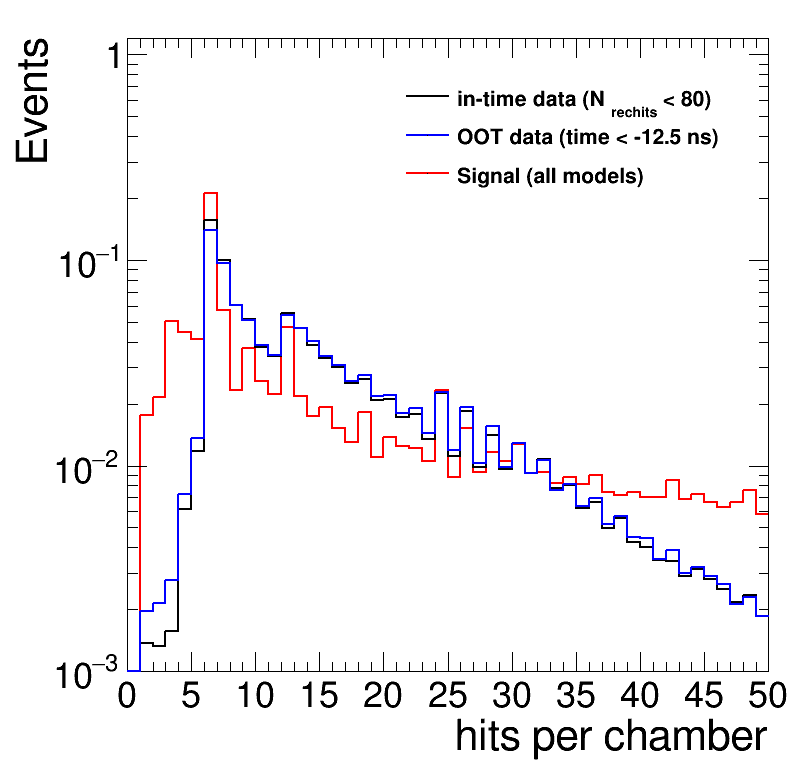

In [10]:


index =0
overflow = True
var = [hit_per_chamber, hit_per_chamber_me1112, hit_per_chamber_notme1112, nCsc, nCsc_sub, diff]
xaxis = ['hits per chamber','hits per chamber','hits per chamber', 'nCsc', 'nCsc', 'difference']
binning = [[50,0,50],[50,0,50],[50,0,50], [30,0,3000], [30,0,3000],[15,0,15]]
with_background = 1
leg = rt.TLegend(0.5,0.75,0.8,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
if overflow:
    for k in ['mc', 'data_intime', 'data_oot']:
        draw = np.copy(np.array(var[index][k]))
        draw[draw>binning[index][2]] = binning[index][2]
        if k == 'mc':h['sig'] = create_TH1D(draw[draw>0],  axis_title=[xaxis[index], 'Events'], binning = binning[index])
        else:h[k] = create_TH1D(draw[draw>0],  axis_title=[xaxis[index], 'Events'], binning = binning[index])
else:
    h['sig'] = create_TH1D(np.array(var[index]['mc'])[np.array(var[index]['mc'])>0],  axis_title=[xaxis[index], 'Events'], binning = binning[index])
    h['data_intime'] = create_TH1D(np.array(var[index]['data_intime'])[np.array(var[index]['data_intime'])>0],  axis_title=[xaxis[index], 'Events'], binning = binning[index])
    h['data_oot'] = create_TH1D(np.array(var[index]['data_oot'])[np.array(var[index]['data_oot'])>0],  axis_title=[xaxis[index], 'Events'], binning = binning[index])
leg.AddEntry(h['data_intime'], 'in-time data (N_{rechits} < 80)')
leg.AddEntry(h['data_oot'], 'OOT data (time < -12.5 ns)')
leg.AddEntry(h['sig'], 'Signal (all models)')
for k, hist in h.items():
    hist.Scale(1./hist.Integral())

h['sig'].GetYaxis().SetRangeUser(0.001,1.2)
# print(np.count_nonzero(np.array(var[index]['mc'].flatten())>130)/len(np.array(var[index]['mc'].flatten())))
if with_background: h['sig'].SetLineColor(2)
else:h['sig'].SetLineColor(1)
h['sig'].DrawNormalized('hist same')
if with_background:
#         if index<=7:
#             h['data_intime'].SetLineColor(1)
#             h['data_intime'].Draw('hist same')
#             if index > 0 and index <7:
#                 h['data_oot'].SetLineColor(4)
#                 h['data_oot'].Draw('hist same')
#         else:
#             h['data_oot'].SetLineColor(1)
#             h['data_oot'].Draw('hist same')
    h['data_intime'].SetLineColor(1)
    h['data_intime'].Draw('hist same')
    h['data_oot'].SetLineColor(4)
    h['data_oot'].Draw('hist same')
    leg.Draw()



c.SetRightMargin(0.034)
c.SetLogy()

c.Draw()
outDir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/signal_efficiencies/'+analyzer_version
#     if not os.path.isdir(outDir):os.makedirs(outDir)
#     if with_background:
#         c.SaveAs(outDir+name[index]+'.png')
#         c.SaveAs(outDir+name[index]+'.C')
#     else:
#         c.SaveAs(outDir+name[index]+'_sig.png')
#         c.SaveAs(outDir+name[index]+'_sig.C')

